# What can the age of police fatalities tell us about the world?
Why are police officers shooting younger people in certain cities in the United States?  There are many possibiliities that lead to important questions, including :
1. Are there particular interventions necessary to address youth crime and gang activity?
2. Are new police trainings required to address populations differently?
3. Will preventative measures to decrease differ from city to city?

Alternatively, is it merely the case that cities differ in their age distributions?  We will strive to analyze several variables that may contribute to such differences.

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
import seaborn as sns

from scipy.stats import ttest_ind

In [165]:
#load and transform data
median_household_income = pd.read_csv('MedianHouseholdIncome2015.csv', encoding="windows-1252")
police_killings = pd.read_csv('PoliceKillingsUS.csv', encoding="windows-1252")
city_population_2015 = pd.read_csv('city_populations_2015.csv')


#median transformation:  
#delete medians that aren't numeric
#delete non-cities
#update NY, Wash. DC
#update col names:  city, state

#city population transformation
#Join in 2 letter codes for states
#Update Washington DC

## Data

We will be working with the fatal police shootings data set, which spans from January 2015 - December 2017 for United States cities. Additionally, we will incorporate US Census data for median income and population by city.  The 3 datasets used are:

**1. PoliceKillingsUS.csv:**([Kaggle Dataset](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/data))
The Washington Post is tracking more than a dozen details about each killing - including the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. They have gathered this information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases. This dataset only contains shootings in which a police officer, in the line of duty, shot and killed a civilian. It does not track deaths of people in police custody, fatal shootings by off-duty officers or non-shooting deaths.

**2. MedianHouseholdIncome2015.csv:**([Kaggle Dataset](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/data))
In order to investigate the link between police shootings and income, we used US Census data containing the median household income in all US cities.


**3. city_populations_2015.csv:**([Census Data](http://www.governing.com/gov-data/census/2014-city-population-estimates-data-table.html))
In order to normalize fatality counts by city, we used US Census data containing the 2015 population in all US cities.



## Exploring age distributions in cities with the highest number of police fatalities
Los Angeles has seen the most police fatalities, with 39 over the span of two years from 2015 - 2017.  
Most police fatalities are between the ages of 25-35, but the age distributions differ from city to city.  For example, the age range of police fatalities in Tucson is narrower than Miami.  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

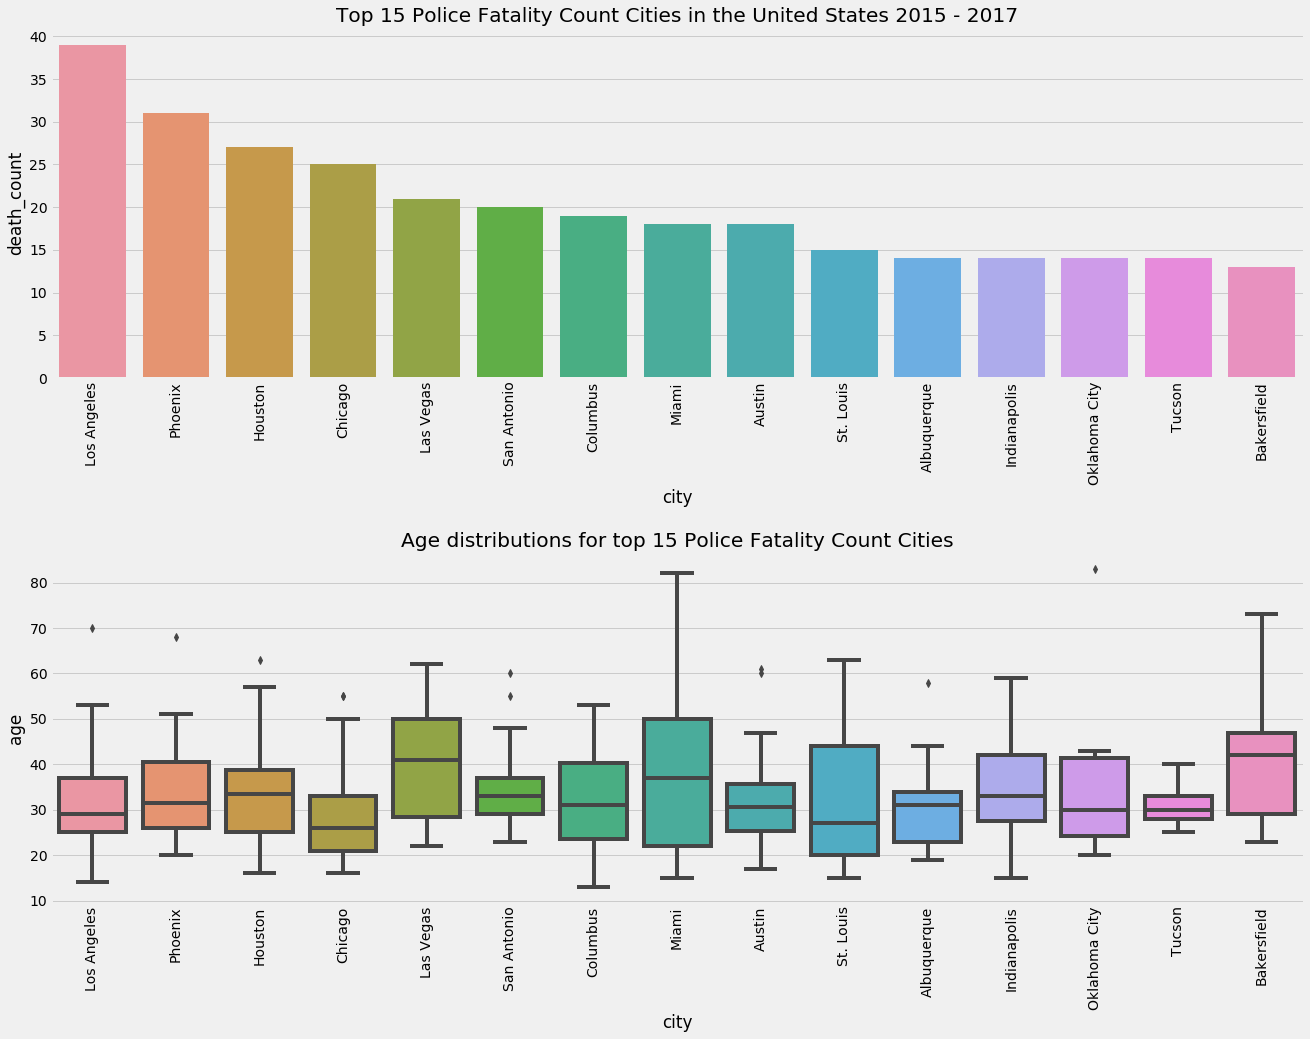

In [166]:
plt.style.use('fivethirtyeight')

#Create dataframe for top 15 cities with most police fatalities
df_top = police_killings[['city', 'name']].groupby('city').count().sort_values(['name'], ascending=[False]).head(15)
df_top.reset_index(level=0, inplace=True)

new_columns = df_top.columns.values
new_columns[1] = 'death_count'
df_top.columns = new_columns

#plots
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=.5)

#top 15 counts
plt.subplot(2, 1, 1)
sns.barplot(x="city", y="death_count", data=df_top)
plt.title('Top 15 Police Fatality Count Cities in the United States 2015 - 2017')
plt.xticks(rotation=90)

#Age ranges for police fatalities
df2_top = pd.merge(df_top, police_killings, on='city', how='left')
plt.subplot(2, 1, 2)
sns.boxplot(x='city', y='age', data=df2_top, order=["Los Angeles", "Phoenix", "Houston","Chicago","Las Vegas", "San Antonio", "Columbus", "Miami", "Austin", "St. Louis", "Albuquerque","Indianapolis","Oklahoma City","Tucson","Bakersfield"])
plt.title('Age distributions for top 15 Police Fatality Count Cities')
plt.xticks(rotation=90)

While it's useful to see age ranges for specific cities, the death count itself may be misleading, since it does not account for the city's population.  Therefore, it's useful to analyze the death count per million people in order to normalize death counts across cities with different populations.

In doing so, you can begin to evaluate whether the normalized death count is linked to other variables.  We've created a histogram to look at the the income level and police fatality count per million for cities overall.  It appears that most cities have median incomes between $40,000 and $50,000, and police fatality counts per million of 10-15.

Also, we've plotted the death count per million against the median income.  There appears to be an inverse relationship between fatality count per million people and median income, where higher income cities have lower fatality counts.  

In [167]:
#Group killings by city and add count (death_count)
df = police_killings.groupby(['city', 'state']).size().reset_index(name='death_count').sort_values(['death_count'], ascending=[False])

#Replace the word ' city' with empty string since each city contains this string at the end
median_household_income['city'] = median_household_income['city'].str.replace(' city','')

#Join grouped death count by city with median income by city, and then with city population
df2 = pd.merge(df, median_household_income, on=['city','state'], how='outer')
df3 = pd.merge(df2, city_population_2015, on=['city','state'], how='outer')

#Where cities aren't found, drop the record
df3 = df3.dropna(subset=['median_income'])
df3 = df3.dropna(subset=['pop'])
df3 = df3.dropna(subset=['death_count'])

#Determine median income level to assign low/high income
df3.describe()

#median income = 48617.500000
df3['income_level'] = 'other'
df3.loc[df3['median_income'] <= 48617.500000, 'income_level'] = 'low'
df3.loc[df3['median_income'] > 48617.500000, 'income_level'] = 'high'
df3['death_count_per_million'] = (df3['death_count']/df3['pop'])*1000000

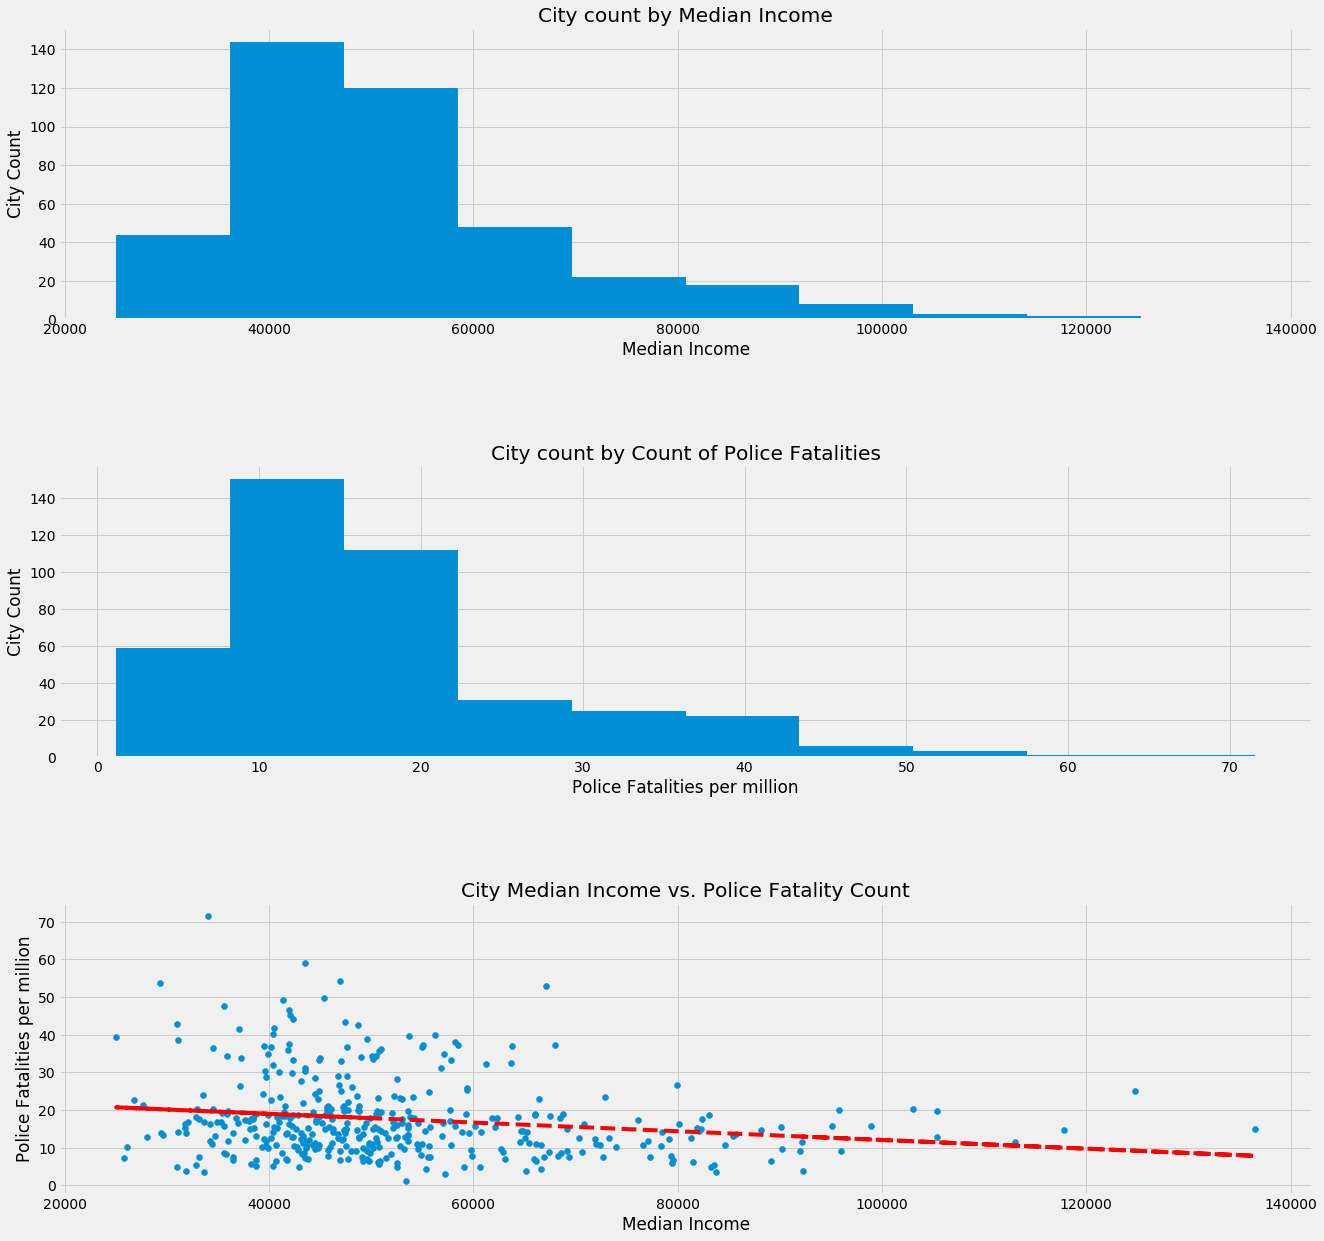

In [171]:
#Plot the data
plt.style.use('fivethirtyeight')
x = df3['median_income']
y = df3['death_count_per_million']

#plots
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
plt.hist(x) 
plt.ylabel('City Count')
plt.xlabel('Median Income')
plt.title('City count by Median Income')

plt.subplot(3, 1, 2)
plt.hist(y) 
plt.ylabel('City Count')
plt.xlabel('Police Fatalities per million')
plt.title('City count by Count of Police Fatalities')

plt.subplot(3, 1, 3)
plt.scatter(x, y)
plt.ylabel('Police Fatalities per million')
plt.xlabel('Median Income')
plt.title('City Median Income vs. Police Fatality Count')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")



In [145]:
#Add classification columns
df4 = pd.merge(police_killings, df3, on=['city','state'], how='inner')
df4 = df4.dropna(subset=['age'])

df4['armed_unarmed'] = 'other'
df4.loc[df4['armed'] != 'unarmed', 'armed_unarmed'] = 'armed'
df4.loc[df4['armed'] == '', 'armed_unarmed'] = 'other'
df4.loc[df4['armed'] == 'undetermined', 'armed_unarmed'] = 'other'
df4.loc[df4['armed'] == 'unknown weapon', 'armed_unarmed'] = 'other'
df4.loc[df4['armed'] == 'unarmed', 'armed_unarmed'] = 'unarmed'

df5 = df4[df4['income_level']=='low']
df6 = df4[df4['income_level']=='high']
df7 = df4[df4['armed_unarmed']=='armed']
df8 = df4[df4['armed_unarmed']=='unarmed']

x_all = df4['age'].sort_values()
x_low = df5['age'].sort_values()
x_high = df6['age'].sort_values()
x_armed = df7['age'].sort_values()
x_unarmed = df8['age'].sort_values()


x_all.to_csv('my_data.csv')

Ttest_indResult(statistic=3.4508014946481156, pvalue=0.00077169163694452113)
Ttest_indResult(statistic=-0.026545536491310112, pvalue=0.97882830492780837)


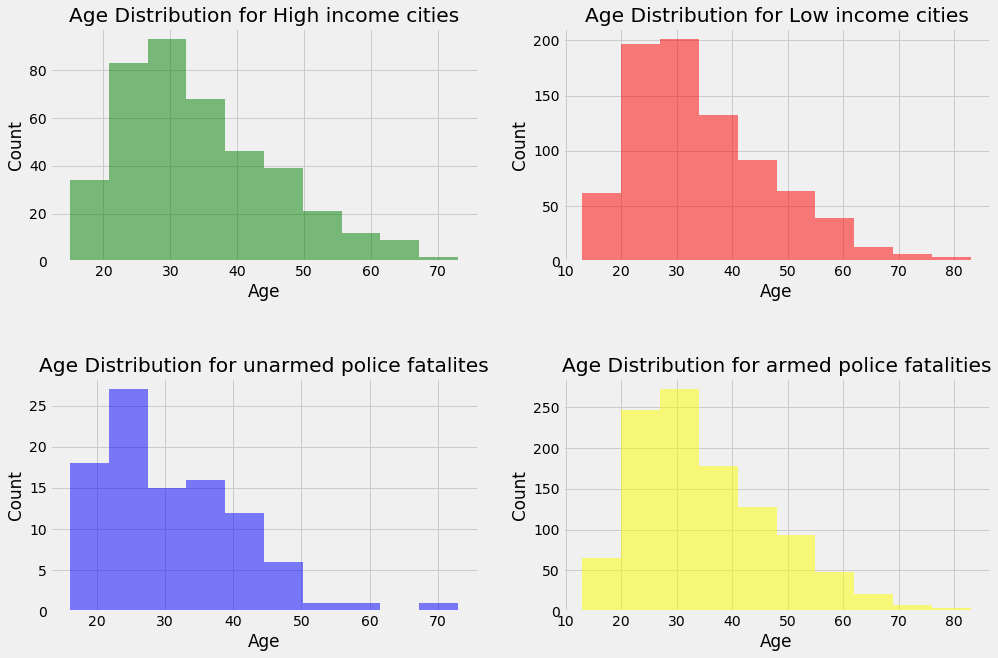

In [143]:
plt.style.use('fivethirtyeight')

#plots
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=.5)

plt.subplot(2, 2, 1)
plt.hist(x_high, color='green', alpha=.5)
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution for High income cities')


plt.subplot(2, 2, 2)
plt.hist(x_low, color='red', alpha=.5) 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution for Low income cities')

plt.subplot(2, 2, 3)
plt.hist(x_unarmed, color='blue', alpha=.5)
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution for unarmed police fatalites')


plt.subplot(2, 2, 4)
plt.hist(x_armed, color='yellow', alpha=.5) 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution for armed police fatalities')

print(ttest_ind(x_armed, x_unarmed, equal_var=False))
print(ttest_ind(x_low, x_high, equal_var=False))




One way to interpret a t-value is as the number of standard errors worth of space separating the group means. A t-value of 3.45 would indicate that the means are 3.5 standard errors apart.

The p-value associated with a t-test indicates the likelihood of getting a difference this large or larger in the samples if the populations were not different. The smaller the p-value, the more likely the difference we see in the samples meaningfully reflects the populations. The p-value in the test you did above is really small, so we can be fairly confident that the difference in means we see is due to a real difference in the population and not due to variability in the samples.

Text(0.5,1,'QQ Plot - Gamma Distribution for police fatality Age')

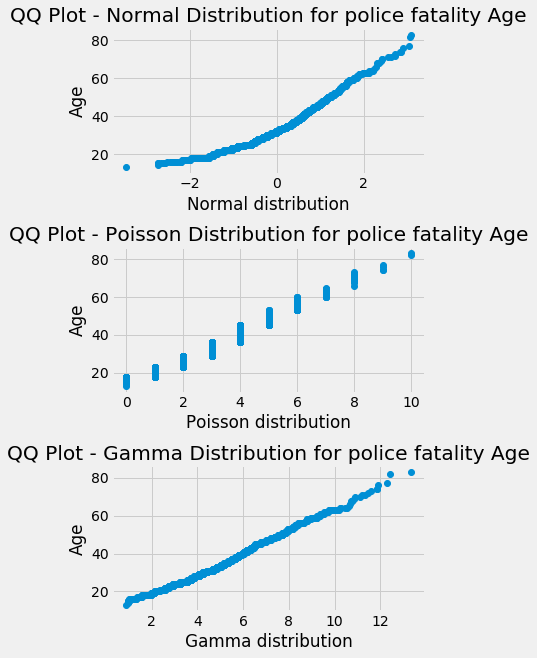

In [108]:

# Making a standard normally distributed variable with 1000 observations,
# a mean of 0, and standard deviation of 1 that we will use as our “comparison.”
norm = np.random.normal(0, 1, 1218)
poisson = np.random.poisson(3, 1218)
gamma = np.random.gamma(5,1, 1218)

# Sorting the values in ascending order.
norm.sort()
poisson.sort()
gamma.sort()


#plots
plt.figure(figsize=(5, 10))
plt.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
plt.plot(norm, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Normal distribution')
plt.title('QQ Plot - Normal Distribution vs. police fatality Age')

plt.subplot(3, 1, 2)
plt.plot(poisson, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Poisson distribution')
plt.title('QQ Plot - Poisson Distribution vs. police fatality Age')

plt.subplot(3, 1, 3)
plt.plot(gamma, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Gamma distribution')
plt.title('QQ Plot - Gamma Distribution vs. police fatality Age')

